<a href="https://colab.research.google.com/github/ThOpaque/Binary_Classifier_DeepLearning/blob/main/VGG16_FCN8_CamVid_TF_to_PT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np

import torch
import torchvision
!pip install torch-summary
from torchsummary import summary

from matplotlib import pyplot as plt
import seaborn as sns


import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# download the dataset (zipped file)
!gdown --id 0B0d9ZiqAgFkiOHR1NTJhWVJMNEU -O /tmp/fcnn-dataset.zip 

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=0B0d9ZiqAgFkiOHR1NTJhWVJMNEU
To: /tmp/fcnn-dataset.zip
100% 126M/126M [00:02<00:00, 59.1MB/s]


In [3]:
# extract the downloaded dataset to a local directory: /tmp/fcnn
local_zip = '/tmp/fcnn-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/fcnn')
zip_ref.close()

In [4]:
# show folders inside the dataset you downloaded
!ls /tmp/fcnn/dataset1

annotations_prepped_test   images_prepped_test
annotations_prepped_train  images_prepped_train


In [9]:
# pixel labels in the video frames
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 
               'vegetation', 'traffic light', 'fence', 'vehicle', 
               'pedestrian', 'byciclist', 'void']

In [13]:
class CamVid_Dataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, anno_map_dir, class_names, height=224, width=224):      
        self.height = height
        self.width = width

        # generates the lists of image and label map paths
        image_file_list = os.listdir(image_dir)
        anno_map_file_list = os.listdir(anno_map_dir)
        self.image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
        self.anno_map_paths = [os.path.join(anno_map_dir, fname) for fname in anno_map_file_list]
        
        self.class_names = class_names

    def __len__(self):
        return len(self.image_paths)

    def preprocess(self, img_path, anno_path):
        # reading
        image = torchvision.io.read_image(img_path)
        annotation = torchvision.io.read_image(anno_path)

        # resizing
        image = torchvision.transforms.Resize((self.height, self.width))(image)
        annotation = torchvision.transforms.Resize((self.height, self.width))(annotation).to(torch.int32)

        # Reshape segmentation masks
        stack_list = []
        for c in range(len(self.class_names)):
            mask = torch.eq(annotation[0, :, :], torch.as_tensor(c, dtype=torch.int32))
            stack_list.append(mask)
        annotation = torch.stack(stack_list, dim=2)
        
        # Normalizing between -1 and 1
        image = image / 127.5
        image -= 1

        return image, annotation


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()

        image, annotation = self.preprocess(self.image_paths[idx], self.anno_map_paths[idx])

        return image, annotation

In [15]:
BATCH_SIZE = 64

training_dataset = CamVid_Dataset('/tmp/fcnn/dataset1/images_prepped_train/','/tmp/fcnn/dataset1/annotations_prepped_train/', class_names)
validation_dataset = CamVid_Dataset('/tmp/fcnn/dataset1/images_prepped_test/','/tmp/fcnn/dataset1/annotations_prepped_test/', class_names)

training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))

# print class name - normalized RGB tuple pairs
# the tuple values will be multiplied by 255 in the helper functions later
# to convert to the (0,0,0) to (255,255,255) RGB values you might be familiar with
for class_name, color in zip(class_names, colors):
  print(f'{class_name} -- {color}')

sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
byciclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


In [53]:
# Visualization Utilities

def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Args:
    images (list of numpy arrays) - numpy array representations of the images to paste
  
  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]
  
  return new_im


def give_color_to_annotation(annotation, colors):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array
  
  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(12):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*(colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*(colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*(colors[c][2] * 255.0)
  
  return seg_img


def show_predictions(image, labelmaps, titles, colors, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps

  Args:
    image (numpy array) -- the input image
    labelmaps (list of arrays) -- contains the predicted and ground truth label maps
    titles (list of strings) -- display headings for the images to be displayed
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each vlass
  '''

  true_img = give_color_to_annotation(labelmaps[1], colors)
  pred_img = give_color_to_annotation(labelmaps[0], colors)

  image = image + 1
  image = image * 127.5
  images = np.uint8([image, pred_img, true_img])

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list) 

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.title(titles[idx], fontsize=12)
    plt.imshow(im)


def show_annotation_and_image(image, annotation, colors):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann, colors)
  
  image = image + 1
  image = image * 127.5
  image = np.uint8(image)
  images = [image, seg_img]
  
  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset, colors, nb_display=9):
  '''
  Displays images and its annotations side by side

  Args:
    dataset (tf Dataset) - batch of images and annotations
  '''

  ds_image, ds_annotation = next(iter(training_dataloader))
  idx = torch.randint(0, len(ds_image), (nb_display,))

  plt.figure(figsize=(25, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  for idx, (image, annotation) in enumerate(zip(ds_image[idx], ds_annotation[idx])):
    plt.subplot(3, 3, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy(), colors)


TypeError: ignored

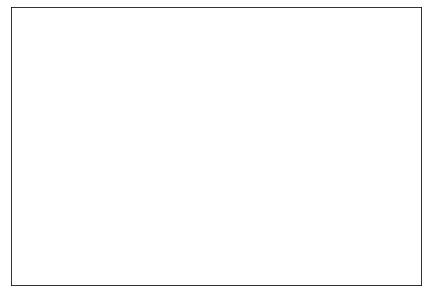

In [56]:
list_show_annotation(training_dataloader, colors)